In this notebook we will consider various Hopf RGB links and create the knots K_B^{0,n} and K_G^{0,n} for small values of n. Then we will compute various knot invariants of these knots and in particular distinguish them. We will also verify that the knots really share four surgeries.

First we load the necessary functions.

In [1]:
import snappy
import time

### Find positive triangulations

def all_positive(manifold):
    '''
    Checks if the solution type of a triangulation is positive.
    '''
    return manifold.solution_type() == 'all tetrahedra positively oriented'

def find_positive_triangulations(manifold,number=1,tries=100):
    '''
    Searches for one triangulation with a positive solution type.
    (Or if number is set to a different value also for different such triangulations.)
    '''
    M = manifold.copy()
    pos_triangulations=[]
    for i in range(tries):
        if all_positive(M):
            pos_triangulations.append(M)
            if len(pos_triangulations)==number:
                return pos_triangulations
            break
        M.randomize()
    for d in M.dual_curves(max_segments=500):
        X = M.drill(d)
        X = X.filled_triangulation()
        X.dehn_fill((1,0),-1)
        for i in range(tries):
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
                break
            X.randomize()

    # In the closed case, here is another trick.
    if all(not c for c in M.cusp_info('is_complete')):
        for i in range(tries):
            # Drills out a random edge
            X = M.__class__(M.filled_triangulation())
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
            break
            M.randomize()
    return pos_triangulations

### CHECKING FOR ISOMETRIES

def better_is_isometric_to(X,Y,return_isometries=False,index=100,try_hard=False):
    """
    Returns True if X and Y are isometric.
    Returns False if SnapPy could not verify it.
     """ 
    if return_isometries==False:
        if X.homology()!=Y.homology():
            return False
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y)
                if w:
                    return w
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            X.randomize()
            Y.randomize()
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=2,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=2,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,index=100,try_hard=False)
                    if w==True:
                        return w
        return False
    if return_isometries==True:
        if X.homology()!=Y.homology():
            return []
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y,return_isometries)
                if w!=False:
                    return w
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            X.randomize()
            Y.randomize()
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=2,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=2,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,return_isometries,index=100,try_hard=False)
                    if w!=[]:
                        return w
        return []
    
def orientation_preserving_isometric(M,N,index=100,try_hard=False):
    '''
    Searches for an orientation preserving isometry.
    '''
    for c in M.dual_curves(max_segments=500):
        P=M.drill(c)
        for d in N.dual_curves(max_segments=500):
            Q=N.drill(d)
            for isom in better_is_isometric_to(P,Q,return_isometries=True,index=index,try_hard=try_hard):
                if isom.extends_to_link():
                    if isom.cusp_maps()[0].determinant()==1:
                        return True
    return False

### Invariants

def better_volume(M,index=100,try_hard=False):
    '''Computes the verified volume. Returns 0 if SnapPy could not do it.'''
    count=0
    while count<index:
        try:
            return M.volume(verified=True)
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=1,tries=index)
        for X in pos_triang:
            vol=better_volume(X,index)
            if vol!=0:
                return vol
    return 0

def better_find_canonical_triangulation(M,index=100,try_hard=False):
    '''Computes the canonical triangulation. Returns None if SnapPy could not do it.'''
    count=0
    while count<index:
        try:
            return M.canonical_retriangulation()
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=1,tries=index)
        for X in pos_triang:
            can=better_find_canonical_triangulation(X,index)
            if can!=None:
                return can
    return None

def better_create_diagram(M,index=100,try_hard=False):
    '''Creates a knot diagram. Returns None if SnapPy could not do it.'''
    count=0
    while count<index:
        try:
            return M.exterior_to_link()
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=1,tries=index)
        for X in pos_triang:
            D=better_create_diagram(X,index)
            if D!=None:
                return D
    return None

def subgroups_of_order_n(M,n):
    '''
    Returns the number of subgroups of order n of the fundamental group of M.
    Warning: Works only fast for small n.
    '''
    return len(snappy.Manifold(M).covers(n))

def subgroups_up_to_order_k(M,k):
    '''
    Returns the vector containing the number of subgroups of order n of the fundamental group of M for n=2,...,k.
    Warning: Works only fast for small k.
    '''
    vector=[]
    for n in range(2,k+1):
        vector.append(subgroups_of_order_n(M,n))
    return vector

def better_symmetry_group(M,index=100,num_pos_triang=1):
    '''
    This function computes the symmetry group of the input manifold. 
    If the second entry is True it is proven to be the symmetry group.
    '''
    full=False
    S='unclear'
    try:
        S=M.symmetry_group()
        full=S.is_full_group()
        if full:
            return (S,full)
    except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
        pass
    pos_triang=find_positive_triangulations(M,tries=index,number=num_pos_triang)
    if pos_triang==[]:
        randomizeCount=0
        while randomizeCount<index and full==False:
            try:
                S=M.symmetry_group()
                full=S.is_full_group()
                if full:
                    return (S,full)
                M.randomize()
                randomizeCount=randomizeCount+1
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                M.randomize()
                randomizeCount=randomizeCount+1
    for X in pos_triang:
        randomizeCount=0
        while randomizeCount<index and full==False:
            try:
                S=X.symmetry_group()
                full=S.is_full_group()
                if full:
                    return (S,full)
                X.randomize()
                randomizeCount=randomizeCount+1
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                X.randomize()
                randomizeCount=randomizeCount+1
    return (S,full)

def better_cusp_areas(A,index=100,try_hard=False):
    '''Computes the verified cusp areas. Returns 0 if SnapPy could not do it.'''
    M=A.high_precision()
    count=0
    while count<index:
        try:
            return M.cusp_areas(verified=True)
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=1,tries=index)
        for X in pos_triang:
            vol=better_cusp_areas(X,index)
            if vol!=0:
                return vol
    return 0

#### Hopf RGB links

def create_pairs(RBG,k,m):
    '''
    Takes as input a Hopf RGB link with components 0=red, 1=blue and 2=green and two integers k<m.
    It creates the pairs of knots (K_B^{0,n}, K_G^{0,n}) for k<n<m and returns them as a list.
    '''
    pairs=[]
    for n in range(k+1,m):
        L.dehn_fill([(0,1),(n,1),(0,0)])
        KG=L.filled_triangulation()
        KG.set_peripheral_curves( [[[KG.homological_longitude()[1], 0], [KG.homological_longitude()[0], KG.homological_longitude()[1]]]])
        KG.set_name('KG_'+str(n))   
        
        L.dehn_fill([(0,1),(0,0),(n,1)])
        KB=L.filled_triangulation()
        KB.set_peripheral_curves( [[[KB.homological_longitude()[1], 0], [KB.homological_longitude()[0], KB.homological_longitude()[1]]]])
        KB.set_name('KB_'+str(n))
        
        pairs.append([KB,KG])
        
    return pairs


We start with the example Hopf RBG link from Figure 6.

In [2]:
L=snappy.Manifold('MainExampleHopfRBGLink.lnk')

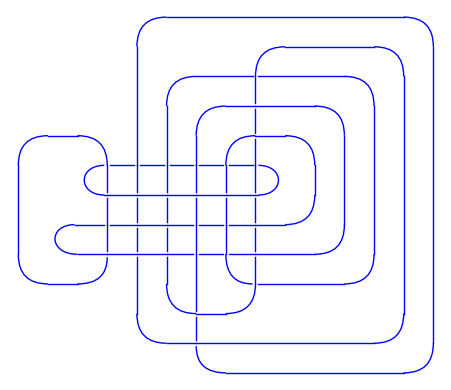

In [3]:
L.link().sage_link().plot()

First we create the knots K_B^{0,n} and K_G^{0,n} for n in [-10,10]:

In [4]:
pairs=create_pairs(L,-21,21)
pairs

[[KB_-20(0,0), KG_-20(0,0)],
 [KB_-19(0,0), KG_-19(0,0)],
 [KB_-18(0,0), KG_-18(0,0)],
 [KB_-17(0,0), KG_-17(0,0)],
 [KB_-16(0,0), KG_-16(0,0)],
 [KB_-15(0,0), KG_-15(0,0)],
 [KB_-14(0,0), KG_-14(0,0)],
 [KB_-13(0,0), KG_-13(0,0)],
 [KB_-12(0,0), KG_-12(0,0)],
 [KB_-11(0,0), KG_-11(0,0)],
 [KB_-10(0,0), KG_-10(0,0)],
 [KB_-9(0,0), KG_-9(0,0)],
 [KB_-8(0,0), KG_-8(0,0)],
 [KB_-7(0,0), KG_-7(0,0)],
 [KB_-6(0,0), KG_-6(0,0)],
 [KB_-5(0,0), KG_-5(0,0)],
 [KB_-4(0,0), KG_-4(0,0)],
 [KB_-3(0,0), KG_-3(0,0)],
 [KB_-2(0,0), KG_-2(0,0)],
 [KB_-1(0,0), KG_-1(0,0)],
 [KB_0(0,0), KG_0(0,0)],
 [KB_1(0,0), KG_1(0,0)],
 [KB_2(0,0), KG_2(0,0)],
 [KB_3(0,0), KG_3(0,0)],
 [KB_4(0,0), KG_4(0,0)],
 [KB_5(0,0), KG_5(0,0)],
 [KB_6(0,0), KG_6(0,0)],
 [KB_7(0,0), KG_7(0,0)],
 [KB_8(0,0), KG_8(0,0)],
 [KB_9(0,0), KG_9(0,0)],
 [KB_10(0,0), KG_10(0,0)],
 [KB_11(0,0), KG_11(0,0)],
 [KB_12(0,0), KG_12(0,0)],
 [KB_13(0,0), KG_13(0,0)],
 [KB_14(0,0), KG_14(0,0)],
 [KB_15(0,0), KG_15(0,0)],
 [KB_16(0,0), KG_16(0,0)],

Next we compare the various knot invariants and in particular show that the canonical triangulations and the homflypt polynomials (and sometimes the number of covers) can distinguish these knots, while all other standard invariants seem to agree.

In [5]:
### Comparing the canonical triangulations.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    CB=better_find_canonical_triangulation(B,try_hard=True)
    CG=better_find_canonical_triangulation(G,try_hard=True)
    if CB!=None:
        if CG!=None:
            if CB.num_tetrahedra()==CG.num_tetrahedra():
                if CB.isomorphisms_to(CG)==[]:
                    different.append([B,G])
                else:
                    same.append([B,G])
            else:
                different.append([B,G])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G]) 
        
print('Knots where the canonical triangulations are the same:',same)
print('Knots where the canonical triangulations could not be computed:',unclear)   
print('Time taken:',(time.time()-start_time)/60,' minutes')

Knots where the canonical triangulations are the same: [[KB_-1(0,0), KG_-1(0,0)], [KB_0(0,0), KG_0(0,0)], [KB_1(0,0), KG_1(0,0)]]
Knots where the canonical triangulations could not be computed: []
Time taken: 0.0007259805997212727  minutes


In [6]:
### Comparing the Alexander polynomials.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    aB=B.alexander_polynomial()
    aG=G.alexander_polynomial()
    if aB==aG:
        same.append([B,G])
    else:
        different.append([B,G])
        
print('Number of knots where the Alexander polynomials are equal:',len(same))
print('Knots where the Alexander polynomials are different:',len(different))
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the Alexander polynomials are equal: 41
Knots where the Alexander polynomials are different: 0
Time taken: 0.00478131373723348  minutes


In [7]:
### Comparing the symmetry groups.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    SB=better_symmetry_group(B)
    SG=better_symmetry_group(G)
    if SB[1]==True:
        if SG[1]==True:
            if SB[0].order()==SG[0].order():
                same.append([B,G])
            else:
                different.append([B,G])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G]) 
        
print('Number of knots where the symmetry groups are the same:',len(same))
print('Knots with different symmetry groups:',different)  
print('Knots where the symmetry group could not be computed:',unclear)   
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the symmetry groups are the same: 41
Knots with different symmetry groups: []
Knots where the symmetry group could not be computed: []
Time taken: 0.0005512317021687825  minutes


In [8]:
### Comparing the volumes.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    volB=better_volume(B,try_hard=True)
    volG=better_volume(G,try_hard=True)
    if volB!=0:
        if volG!=0:
            if volB.overlaps(volG):
                same.append([B,G])
            else:
                different.append([B,G])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G]) 
        
print('Number of knots where the volumes overlap:',len(same))
print('Knots with different volumes:',different)  
print('Knots where the volumes could not be computed:',unclear)   
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the volumes overlap: 41
Knots with different volumes: []
Knots where the volumes could not be computed: []
Time taken: 0.04754587014516195  minutes


In [9]:
### Comparing the cusp areas.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    volB=better_cusp_areas(B,try_hard=True)
    volG=better_cusp_areas(G,try_hard=True)
    if volB!=0:
        if volG!=0:
            if volB[0].overlaps(volG[0]):
                same.append([B,G])
            else:
                different.append([B,G])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G]) 
        
print('Number of knots where the cusp areas overlap:',len(same))
print('Knots with different cusp areas:',different)  
print('Knots where the cusp areas could not be computed:',unclear)   
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the cusp areas overlap: 41
Knots with different cusp areas: []
Knots where the cusp areas could not be computed: []
Time taken: 0.222506316502889  minutes


In [10]:
### Comparing the number of covers of degree d.
start_time=time.time()
d=3
print('We look at covers of degree:',d)

different=[]
same=[]

for [B,G] in pairs:
    sB=subgroups_of_order_n(B,d)
    sG=subgroups_of_order_n(G,d)
    if sB==sG:
        same.append([B,G])
    else:
        different.append([B,G])
 
        
print('Number of knots where the number of covers agree:',len(same))
print('Knots with different numbers of covers:',different)  
print('Time taken:',(time.time()-start_time)/60,' minutes')

We look at covers of degree: 3
Number of knots where the number of covers agree: 41
Knots with different numbers of covers: []
Time taken: 0.003764617443084717  minutes


In [11]:
### Comparing the number of covers of degree d.
start_time=time.time()
d=4
print('We look at covers of degree:',d)

different=[]
same=[]

for [B,G] in pairs:
    sB=subgroups_of_order_n(B,d)
    sG=subgroups_of_order_n(G,d)
    if sB==sG:
        same.append([B,G])
    else:
        different.append([B,G])
 
        
print('Number of knots where the number of covers agree:',len(same))
print('Knots with different numbers of covers:',different)  
print('Time taken:',(time.time()-start_time)/60,' minutes')

We look at covers of degree: 4
Number of knots where the number of covers agree: 41
Knots with different numbers of covers: []
Time taken: 0.004775861899058024  minutes


In [12]:
### Comparing the number of covers of degree d.
start_time=time.time()
d=5
print('We look at covers of degree:',d)

different=[]
same=[]

for [B,G] in pairs:
    sB=subgroups_of_order_n(B,d)
    sG=subgroups_of_order_n(G,d)
    if sB==sG:
        same.append([B,G])
    else:
        different.append([B,G])
 
        
print('Number of knots where the number of covers agree:',len(same))
print('Knots with different numbers of covers:',different)  
print('Time taken:',(time.time()-start_time)/60,' minutes')

We look at covers of degree: 5
Number of knots where the number of covers agree: 29
Knots with different numbers of covers: [[KB_-20(0,0), KG_-20(0,0)], [KB_-18(0,0), KG_-18(0,0)], [KB_-16(0,0), KG_-16(0,0)], [KB_-8(0,0), KG_-8(0,0)], [KB_-6(0,0), KG_-6(0,0)], [KB_-4(0,0), KG_-4(0,0)], [KB_4(0,0), KG_4(0,0)], [KB_6(0,0), KG_6(0,0)], [KB_8(0,0), KG_8(0,0)], [KB_16(0,0), KG_16(0,0)], [KB_18(0,0), KG_18(0,0)], [KB_20(0,0), KG_20(0,0)]]
Time taken: 0.04880199829737345  minutes


In [13]:
### Create diagrams
start_time=time.time()

pairs=create_pairs(L,-8,8)

diagrams=[]
unclear=[]

for [B,G] in pairs:
    DB=better_create_diagram(B,try_hard=True)
    DG=better_create_diagram(G,try_hard=True)
    DB.simplify('global')
    DG.simplify('global')
    if DB!=None:
        if DG!=None:
            diagrams.append([B,DB,G,DG])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G])
 
print('Knots where we could not find a diagram:',unclear)  
print('Time taken:',(time.time()-start_time)/60,' minutes')

Knots where we could not find a diagram: []
Time taken: 3.0687294801076255  minutes


In [14]:
diagrams

[[KB_-7(0,0),
  <Link: 1 comp; 240 cross>,
  KG_-7(0,0),
  <Link: 1 comp; 161 cross>],
 [KB_-6(0,0),
  <Link: 1 comp; 136 cross>,
  KG_-6(0,0),
  <Link: 1 comp; 169 cross>],
 [KB_-5(0,0),
  <Link: 1 comp; 122 cross>,
  KG_-5(0,0),
  <Link: 1 comp; 115 cross>],
 [KB_-4(0,0), <Link: 1 comp; 102 cross>, KG_-4(0,0), <Link: 1 comp; 95 cross>],
 [KB_-3(0,0), <Link: 1 comp; 76 cross>, KG_-3(0,0), <Link: 1 comp; 75 cross>],
 [KB_-2(0,0), <Link: 1 comp; 56 cross>, KG_-2(0,0), <Link: 1 comp; 55 cross>],
 [KB_-1(0,0), <Link: 1 comp; 34 cross>, KG_-1(0,0), <Link: 1 comp; 35 cross>],
 [KB_0(0,0), <Link: 1 comp; 12 cross>, KG_0(0,0), <Link: 1 comp; 12 cross>],
 [KB_1(0,0), <Link: 1 comp; 35 cross>, KG_1(0,0), <Link: 1 comp; 36 cross>],
 [KB_2(0,0), <Link: 1 comp; 56 cross>, KG_2(0,0), <Link: 1 comp; 57 cross>],
 [KB_3(0,0), <Link: 1 comp; 76 cross>, KG_3(0,0), <Link: 1 comp; 78 cross>],
 [KB_4(0,0), <Link: 1 comp; 102 cross>, KG_4(0,0), <Link: 1 comp; 99 cross>],
 [KB_5(0,0), <Link: 1 comp; 116 cros

In [15]:
### Comparing the HOMFLYPT polynomials.
start_time=time.time()
var('v')

different=[]
same=[]
unclear=[]
for [B,DB,G,DG] in diagrams:
    aB=DB.sage_link().homfly_polynomial(normalization='vz')
    print(B)
    print(aB(v,0).expand())
    aG=DG.sage_link().homfly_polynomial(normalization='vz')
    print(G)
    print(aG(v,0).expand())
    if aB==aG:
        same.append([B,G])
    else:
        different.append([B,G])
    print('------------')
        
print('Knots where the HOMFLYPT polynomials are equal:',same)
print('Number of knots where the HOMFLYPT polynomials are different:',len(different))
print('Time taken:',(time.time()-start_time)/60,' minutes')


KB_-7(0,0)
63*v^36 - 68*v^34 - 506*v^32 + 1451*v^30 - 1582*v^28 + 797*v^26 - 155*v^24 - 16*v^20 + 60*v^18 - 85*v^16 + 55*v^14 - 15*v^12 + v^10 + 1
KG_-7(0,0)
84*v^36 - 194*v^34 - 192*v^32 + 1035*v^30 - 1273*v^28 + 675*v^26 - 135*v^24 - 9*v^20 + 26*v^18 - 19*v^16 - 9*v^14 + 16*v^12 - 5*v^10 + 1
------------
KB_-6(0,0)
48*v^32 - 52*v^30 - 374*v^28 + 1063*v^26 - 1145*v^24 + 569*v^22 - 109*v^20 - 14*v^18 + 52*v^16 - 73*v^14 + 47*v^12 - 13*v^10 + v^8 + 1
KG_-6(0,0)
63*v^32 - 142*v^30 - 150*v^28 + 767*v^26 - 926*v^24 + 483*v^22 - 95*v^20 - 8*v^18 + 23*v^16 - 17*v^14 - 7*v^12 + 13*v^10 - 4*v^8 + 1
------------
KB_-5(0,0)
35*v^28 - 38*v^26 - 262*v^24 + 735*v^22 - 778*v^20 + 379*v^18 - 83*v^16 + 44*v^14 - 61*v^12 + 39*v^10 - 11*v^8 + v^6 + 1
KG_-5(0,0)
45*v^28 - 98*v^26 - 113*v^24 + 539*v^22 - 634*v^20 + 323*v^18 - 69*v^16 + 20*v^14 - 15*v^12 - 5*v^10 + 10*v^8 - 3*v^6 + 1
------------
KB_-4(0,0)
24*v^24 - 26*v^22 - 170*v^20 + 467*v^18 - 481*v^16 + 217*v^14 - 5*v^12 - 49*v^10 + 31*v^8 - 9*v^6 + 

In [16]:
### Comparing the knot floer homologies.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,DB,G,DG] in diagrams[4:-4]:
    aB=DB.knot_floer_homology()
    aG=DG.knot_floer_homology()
    if aB==aG:
        same.append([B,G])
    else:
        different.append([B,G])
        
print('Number of knots where the knot Floer homology invariants are equal:',len(same))
print('Knots where the knot Floer homology invariants are different:',different)
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the knot Floer homology invariants are equal: 7
Knots where the knot Floer homology invariants are different: []
Time taken: 0.30374369621276853  minutes


In [17]:
### Comparing the signatures.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,DB,G,DG] in diagrams[4:-4]:
    aB=DB.signature()
    aG=DG.signature()
    if aB==aG:
        same.append([B,G])
    else:
        different.append([B,G])
        
print('Number of knots where the signatures are equal:',len(same))
print('Knots where the signatures are different:',different)
print('Time taken:',(time.time()-start_time)/60,' minutes')

Number of knots where the signatures are equal: 7
Knots where the signatures are different: []
Time taken: 0.0009354472160339356  minutes


Similarly, we can check more complicated Hopf RBG links. It is also interesting that we can do the same for Hopf RBG links with fewer ribbon intersections. A concrete example is the following.  

In [47]:
L=snappy.Manifold('3strand_working_complicated.lnk')

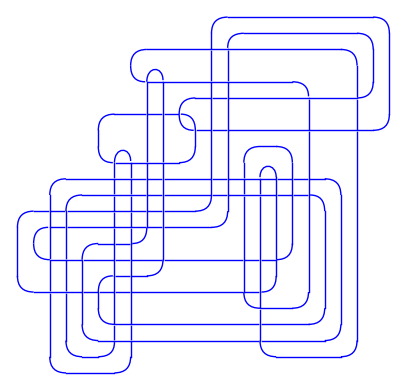

In [48]:
L.link().sage_link().plot()

In [49]:
pairs=create_pairs(L,-11,11)
pairs

[[KB_-10(0,0), KG_-10(0,0)],
 [KB_-9(0,0), KG_-9(0,0)],
 [KB_-8(0,0), KG_-8(0,0)],
 [KB_-7(0,0), KG_-7(0,0)],
 [KB_-6(0,0), KG_-6(0,0)],
 [KB_-5(0,0), KG_-5(0,0)],
 [KB_-4(0,0), KG_-4(0,0)],
 [KB_-3(0,0), KG_-3(0,0)],
 [KB_-2(0,0), KG_-2(0,0)],
 [KB_-1(0,0), KG_-1(0,0)],
 [KB_0(0,0), KG_0(0,0)],
 [KB_1(0,0), KG_1(0,0)],
 [KB_2(0,0), KG_2(0,0)],
 [KB_3(0,0), KG_3(0,0)],
 [KB_4(0,0), KG_4(0,0)],
 [KB_5(0,0), KG_5(0,0)],
 [KB_6(0,0), KG_6(0,0)],
 [KB_7(0,0), KG_7(0,0)],
 [KB_8(0,0), KG_8(0,0)],
 [KB_9(0,0), KG_9(0,0)],
 [KB_10(0,0), KG_10(0,0)]]

In [50]:
### Comparing the canonical triangulations.
start_time=time.time()

different=[]
same=[]
unclear=[]
for [B,G] in pairs:
    CB=better_find_canonical_triangulation(B,try_hard=True)
    CG=better_find_canonical_triangulation(G,try_hard=True)
    if CB!=None:
        if CG!=None:
            if CB.num_tetrahedra()==CG.num_tetrahedra():
                if CB.isomorphisms_to(CG)==[]:
                    different.append([B,G])
                else:
                    same.append([B,G])
            else:
                different.append([B,G])
        else:
            unclear.append([B,G])
    else:
        unclear.append([B,G]) 
        
print('Knots where the canonical triangulations are the same:',same)
print('Knots where the canonical triangulations could not be computed:',unclear)   
print('Time taken:',(time.time()-start_time)/60,' minutes')

Knots where the canonical triangulations are the same: [[KB_-1(0,0), KG_-1(0,0)], [KB_0(0,0), KG_0(0,0)], [KB_1(0,0), KG_1(0,0)]]
Knots where the canonical triangulations could not be computed: []
Time taken: 0.00893728733062744  minutes


We also verify that the constructed Legendrian links are really different.

In [51]:
L=snappy.Manifold('Legendrian_Hopf_RBG.lnk')

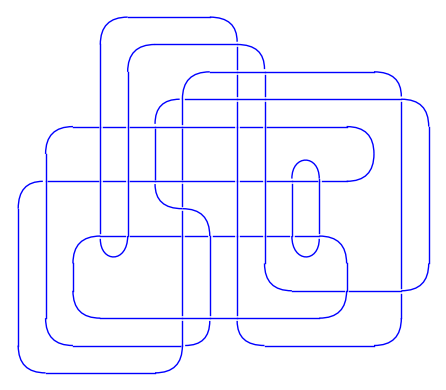

In [52]:
L.link().sage_link().plot()

In [53]:
L.dehn_fill([(0,1),(-2,1),(0,0)])
B=L.filled_triangulation()
B

unnamed link_filled(0,0)

In [54]:
L.dehn_fill([(0,1),(0,0),(-2,1)])
G=L.filled_triangulation()
G

unnamed link_filled(0,0)

In [55]:
B.is_isometric_to(G)

False

In [56]:
CB=B.canonical_retriangulation()
CG=G.canonical_retriangulation()

In [57]:
CG.num_tetrahedra()

22

In [58]:
CB.num_tetrahedra()

21

In [59]:
DB=B.exterior_to_link()
DB

<Link: 1 comp; 72 cross>

In [60]:
DG=G.exterior_to_link()
DG

<Link: 1 comp; 61 cross>

In [61]:
var('v')

v

In [62]:
DG.sage_link().homfly_polynomial(normalization='vz')(v,0).expand()

9*v^22 - 14*v^20 - 32*v^18 + 91*v^16 - 77*v^14 + 26*v^12 - 4*v^10 + v^6 + v^2

In [63]:
DB.sage_link().homfly_polynomial(normalization='vz')(v,0).expand()

8*v^22 - 8*v^20 - 46*v^18 + 105*v^16 - 77*v^14 + 12*v^12 + 10*v^10 - 6*v^8 + 2*v^6 + v^2